In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
titanic_data = pd.read_csv("dataset/train.csv")

In [13]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [15]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


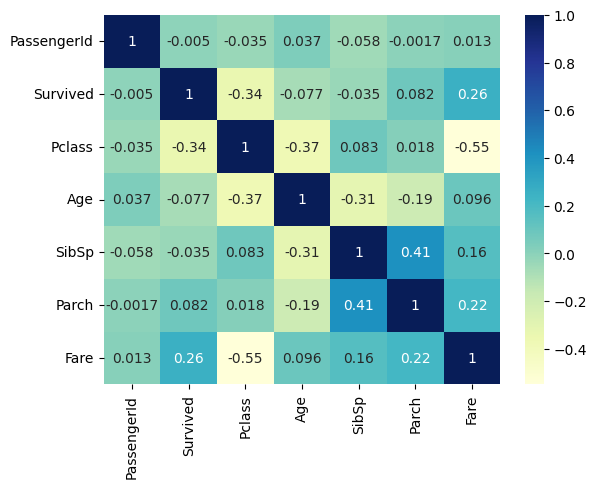

In [16]:
# Sélectionner uniquement les colonnes numériques
numeric_data = titanic_data.select_dtypes(include=[float, int])

# Calculer la corrélation sur les données numériques
sns.heatmap(numeric_data.corr(), annot= True, cmap='YlGnBu')
plt.show()

In [17]:
# Plus les gens étaient dans une classe élevée plus ils survivaient (corrélation négative)
# Plus les gens payaient leur billet cher plus ils survivaient (corrélation positive)

Train set size: 712
Test set size: 179


<Axes: >

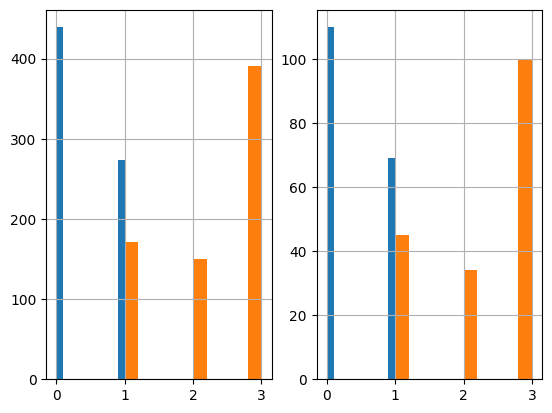

In [18]:
# Nous allons diviser nos data en deux sets, un pour l'entrainement et un pour les tests
# Afin qu'ils ne soient pas biaisés par le hasard nous allons faire en sorte qu'il y aient les mêmes proportions des caractères fortements corrélés
from sklearn.model_selection import StratifiedShuffleSplit

# Séparer les caractéristiques (X) et la cible (y)
X = titanic_data[["Pclass", "Sex"]]  # Caractéristiques que tu veux utiliser
y = titanic_data["Survived"]  # La colonne cible

# Initialiser StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Diviser les données en ensembles d'entraînement et de test
for train_indices, test_indices in split.split(X, y):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

# Vérification de la taille des ensembles
print(f"Train set size: {strat_train_set.shape[0]}")
print(f"Test set size: {strat_test_set.shape[0]}")

# Vérification des proportions
plt.subplot(1,2,1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1,2,2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()


In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

In [20]:
# Nous voulons retravailler les données sous forme binaire pour faciliter l'entrainement 
# Exemple : les villes desquelles ont embarqué les passagers ou le sexe

from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix =encoder.fit_transform(X[['Embarked']]).toarray()
       
        columns_names = ["C","S","Q","N"]

        for i in range(len(matrix.T)):
            X[columns_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[["Sex"]]).toarray()

        columns_names = ["Female", "Male"]

        for i in range(len(matrix.T)):
            X[columns_names[i]] = matrix.T[i]
        
        return X




In [21]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")
    

In [22]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),("featureencoder", FeatureEncoder()),("featuredropper", FeatureDropper())])

In [23]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [24]:
# Vérifiacation
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
692,693,1,3,29.807687,0,0,56.4958,0.0,0.0,1.0,0.0,1.0
481,482,0,2,29.807687,0,0,0.0000,0.0,0.0,1.0,0.0,1.0
527,528,0,1,29.807687,0,0,221.7792,0.0,0.0,1.0,0.0,1.0
855,856,1,3,18.000000,0,1,9.3500,0.0,0.0,1.0,1.0,0.0
801,802,1,2,31.000000,1,1,26.2500,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
359,360,1,3,29.807687,0,0,7.8792,0.0,1.0,0.0,1.0,0.0
258,259,1,1,35.000000,0,0,512.3292,1.0,0.0,0.0,1.0,0.0
736,737,0,3,48.000000,1,3,34.3750,0.0,0.0,1.0,1.0,0.0
462,463,0,1,47.000000,0,0,38.5000,0.0,0.0,1.0,0.0,1.0


In [25]:
# Vérification des valeurs non-nulles
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [26]:
# Transformation des données

from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(["Survived"], axis =1)
y = strat_train_set["Survived"]

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()


In [27]:
# Vérification
X_data


array([[ 9.66222014e-01,  8.29567547e-01, -5.46322934e-16, ...,
         6.16315634e-01, -7.42427274e-01,  7.42427274e-01],
       [ 1.46118705e-01, -3.70944838e-01, -5.46322934e-16, ...,
         6.16315634e-01, -7.42427274e-01,  7.42427274e-01],
       [ 3.24909000e-01, -1.57145722e+00, -5.46322934e-16, ...,
         6.16315634e-01, -7.42427274e-01,  7.42427274e-01],
       ...,
       [ 1.13723882e+00,  8.29567547e-01,  1.39877270e+00, ...,
         6.16315634e-01,  1.34693328e+00, -1.34693328e+00],
       [ 7.22705396e-02, -1.57145722e+00,  1.32188459e+00, ...,
         6.16315634e-01, -7.42427274e-01,  7.42427274e-01],
       [ 2.47174089e-01, -1.57145722e+00, -5.46322934e-16, ...,
         6.16315634e-01, -7.42427274e-01,  7.42427274e-01]])

In [28]:
# Nous entrainerons un modèle de fôret aléatoire car il semble être le plus robuste pour ce type de données

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}

]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [29]:
strat_test_set = pipeline.fit_transform(strat_test_set)
strat_test_set
#strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
565,566,0,3,24.00,2,0,24.1500,0.0,0.0,1.0,0.0,1.0
160,161,0,3,44.00,0,1,16.1000,0.0,0.0,1.0,0.0,1.0
553,554,1,3,22.00,0,0,7.2250,1.0,0.0,0.0,0.0,1.0
860,861,0,3,41.00,2,0,14.1083,0.0,0.0,1.0,0.0,1.0
241,242,1,3,29.25,1,0,15.5000,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
880,881,1,2,25.00,0,1,26.0000,0.0,0.0,1.0,1.0,0.0
91,92,0,3,20.00,0,0,7.8542,0.0,0.0,1.0,0.0,1.0
883,884,0,2,28.00,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
473,474,1,2,23.00,0,0,13.7917,1.0,0.0,0.0,1.0,0.0


In [30]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4, n_estimators=10)

In [31]:
from sklearn.preprocessing import StandardScaler

X_test = strat_test_set.drop(["Survived"], axis=1)
y_test = strat_test_set["Survived"]

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [32]:
final_clf.score(X_data_test, y_data_test)



0.7653631284916201

In [33]:
# Résultat assez précis avec l'échantillon
# Nous allons prendre les données de test complètes pour voir si on obtient une meilleure précision 
final_data = pipeline.fit_transform(titanic_data)

In [34]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [35]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()


In [36]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}

]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [37]:
prod_final_clf = grid_search.best_estimator_

In [38]:
prod_final_clf

RandomForestClassifier(max_depth=5, min_samples_split=4)

In [39]:
# Soumission à Kaggle
titanic_test_data = pd.read_csv("dataset/test.csv")

In [40]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [41]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [42]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)


/var/folders/01/3jwc30js5pndkq3k6gmjmhg80000gn/T/ipykernel_32555/394077634.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [43]:
predictions = prod_final_clf.predict(X_data_final_test)

In [44]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] =predictions
final_df.to_csv("dataset/predictions.csv", index=False)

In [45]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
